<a href="https://colab.research.google.com/github/mizu-YOSUKE/Toho2025/blob/main/2nd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第2回データ分析コンペティション：NFL Draft Prediction

　本ノートブックでは、「スポーツパフォーマンステストおよび選手情報をもとに、NFLドラフト指名の有無（Drafted）を予測する」タスクのベースラインモデルを構築します。

## 1. セットアップ

In [13]:
# Google Driveのマウント（Colab上で自分のデータにアクセスするための設定です）
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# モジュールのインポート
import numpy as np  # 数値計算や配列操作を行うためのライブラリ
import pandas as pd  # 表形式のデータを扱うためのライブラリ
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ
from sklearn.preprocessing import LabelEncoder  # カテゴリ変数を数値に変換するエンコーダ
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレストによる分類器
from sklearn.model_selection import StratifiedKFold  # 層化K分割交差検証を行うクラス
from sklearn.metrics import roc_auc_score  # ROC AUCスコアを計算する評価指標

## 2. データ読み込み

In [15]:
# 読み込むデータが格納されたディレクトリのパス（※必要に応じて変更の必要があります）
PATH = '/content/drive/MyDrive/2025/GCI2025_summer/competition_2/data/'

train = pd.read_csv(PATH + 'train.csv')  # 学習用データの読み込み
test = pd.read_csv(PATH + 'test.csv')    # テスト用データの読み込み

## 3. データの分析・EDA

　**EDA（探索的データ分析）**は、モデル構築の前にデータの構造や特徴を把握するための重要なステップです。

　この段階では、データに含まれる傾向やパターン、外れ値、欠損値、分布の偏りなどを明らかにします。たとえば、ある変数に極端な値があったり、特定のカテゴリにデータが偏っていたりすることがあります。こうした特徴を把握することで、予測に悪影響を及ぼす要因や、有効な特徴量を見つけることができます。

　EDAを行うことで、「欠損値によって学習が進まない」「外れ値の影響でモデルが不安定になる」といった問題を事前に発見し、対処できます。これにより、後工程での手戻りを減らし、効率的な前処理や特徴量設計が可能になります。

　また、EDAで得た知見は、その後のモデル設計やパラメータ調整にも役立ちます。機械学習コンペティションなどでは、最終的なスコア向上にもつながる重要なプロセスです。

　まずは欠損値を確認しておきましょう。機械学習を用いたデータ分析に取り組む上で欠損値の確認は必須となっています。なぜなら、ほとんどの機械学習モデルは欠損値を含むデータに対して学習や予測ができず、エラーとなってしまうからです。

In [16]:
print(train.isnull().sum())
print()
print(test.isnull().sum())

Id                    0
Year                  0
Age                 435
School                0
Height                0
Weight                0
Sprint_40yd         145
Vertical_Jump       554
Bench_Press_Reps    721
Broad_Jump          581
Agility_3cone       970
Shuttle             912
Player_Type           0
Position_Type         0
Position              0
Drafted               0
dtype: int64

Id                    0
Year                  0
Age                 115
School                0
Height                0
Weight                0
Sprint_40yd          29
Vertical_Jump       143
Bench_Press_Reps    184
Broad_Jump          147
Agility_3cone       247
Shuttle             228
Player_Type           0
Position_Type         0
Position              0
dtype: int64


　「Age」「Sprint_40yd」「Vertical_Jump」「Bench_Press_Reps」「Broad_Jump」「Agility_3cone」「Shuttle」列に欠損値があることが分かりました。これらは後で対処することとします。  

　「Drafted」列が1である選手の方が0である選手より多いことが分かりました。割合を見てみましょう。

In [17]:
drafted_percentage = train['Drafted'].value_counts(normalize=True) * 100

print(f"Percentage of 0: {drafted_percentage.get(0, 0):.2f}%")
print(f"Percentage of 1: {drafted_percentage.get(1, 0):.2f}%")

Percentage of 0: 35.17%
Percentage of 1: 64.83%


　ドラフト選出されなかった選手は約35%、ドラフト選出された選手は約65%いることが分かりました。

　その他の特徴量についてもEDAしていきます。まずは「Id」「Drafted」列を除く数値データについて可視化してみましょう。

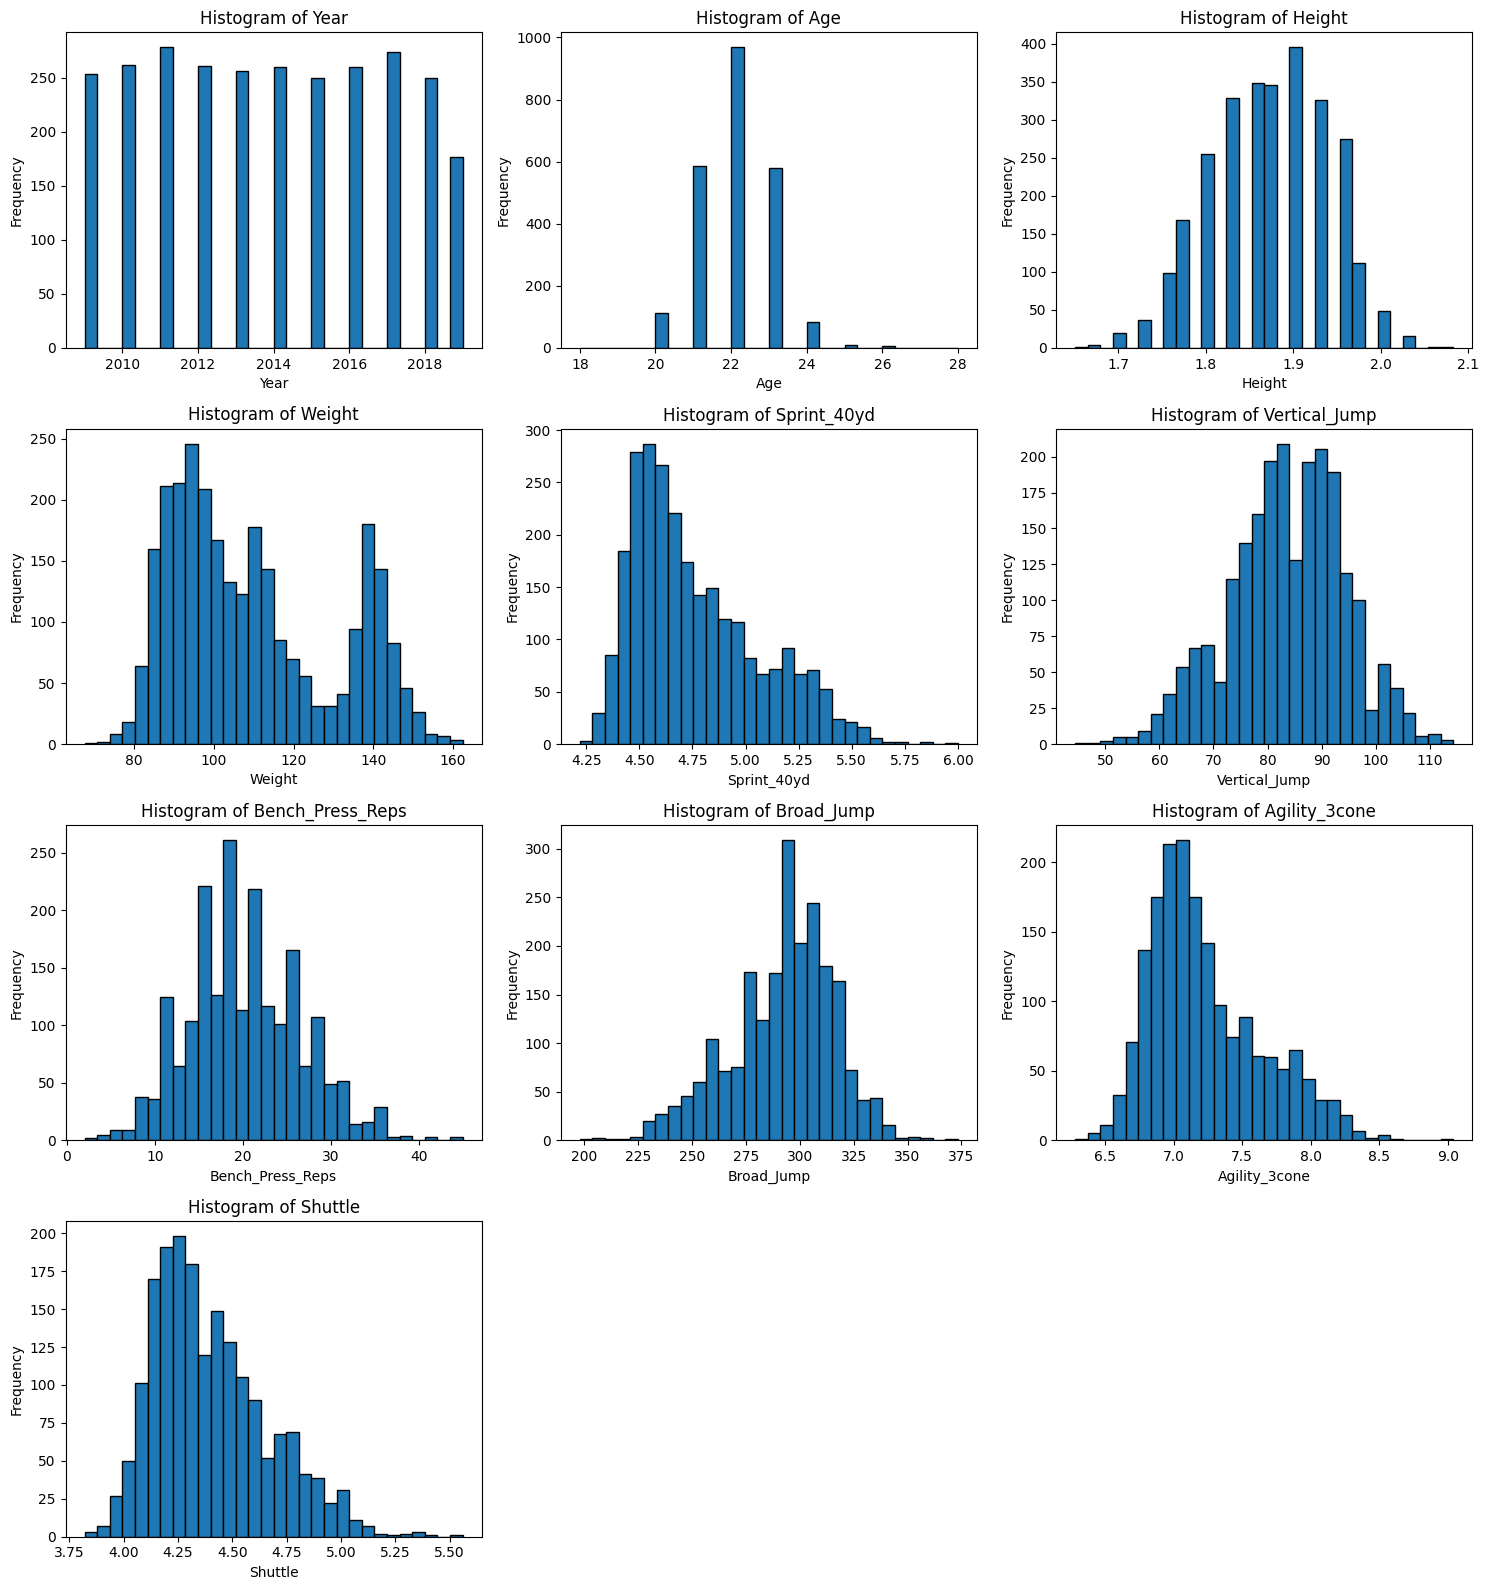

In [18]:
# 数値列だけを取り出す（Id, Drafted列は除く）
numeric_cols = train.select_dtypes(include=['number']).columns
numeric_cols = numeric_cols.drop(['Id', 'Drafted'])

# プロット
num_cols = len(numeric_cols)
cols = 3
rows = (num_cols + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, i)
    plt.hist(train[col].dropna(), bins=30, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

　数値データの相関行列をヒートマップで確認してみましょう。

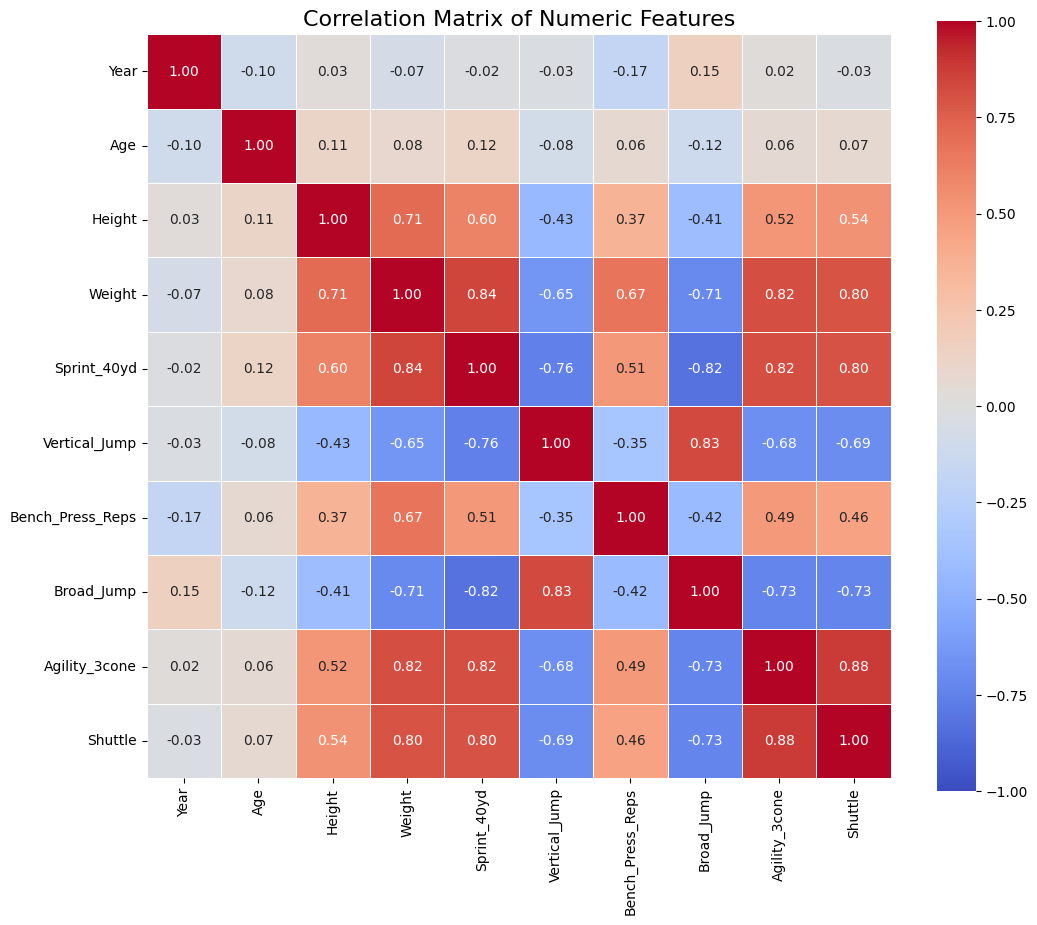

In [19]:
# 数値列だけを取り出す（Id, Drafted列は除く）
numeric_cols = train.select_dtypes(include=['number']).drop(['Id', 'Drafted'], axis=1)

# 相関行列を計算
corr_matrix = numeric_cols.corr()

# ヒートマップをプロット
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5
)

plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.show()

　「Agility_3cone」列と「Shuttle」列の相関係数は0.88であり、強い正の相関関係があることが分かります。これらのスポーツテストでは、似た筋肉や動作が使われている可能性が考えられます。

　一方、「Sprint_40yd」列と「Broad_Jump」列の相関係数は-0.82で、強い負の相関関係が見られました。どちらも主に脚の力を使う種目であるため、通常はスコアが比例する（正の相関になる）と予想されますが、実際には逆の関係が見られています。この理由を探るため、「Sprint_40yd」列を可視化してみます。


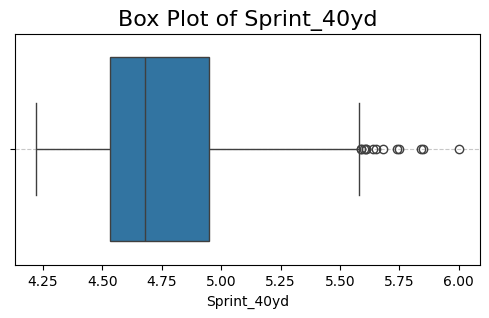

In [20]:
# 箱ひげ図を描画
plt.figure(figsize=(6, 3))
sns.boxplot(x=train['Sprint_40yd'])

plt.title('Box Plot of Sprint_40yd', fontsize=16)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

　可視化されたグラフを見ると、「Sprint_40yd」列の値はおおよそ4.25から6.00の範囲に分布していることがわかります。この数値はスコアではなく実際の走行タイムである可能性が高そうです。40ヤード（約36メートル）を走るタイムとして、中央値が約4.7秒であるのは妥当です。

　つまり、「Sprint_40yd」列の値が小さいほど速く走れたことを意味し、 数値が小さい＝パフォーマンスが高い という点で、他の 数値が大きいほど良い スコアとは逆の関係になっていたのです。

 データを可視化することで、「なぜ負の相関があるのか？」という疑問を解決することができました。

　次は、カテゴリデータについて可視化してみましょう。

In [21]:
# カテゴリデータを抽出
categorical_cols = train.select_dtypes(include=['object', 'category']).columns

# 各列の水準数を取得
levels_count = {col: train[col].nunique() for col in categorical_cols}

for col, count in levels_count.items():
    print(f"{col}: {count} levels")


School: 236 levels
Player_Type: 3 levels
Position_Type: 7 levels
Position: 20 levels


　Schoolは水準数が236とかなり多く、可視化すると潰れて見づらいのでここでは可視化しません。

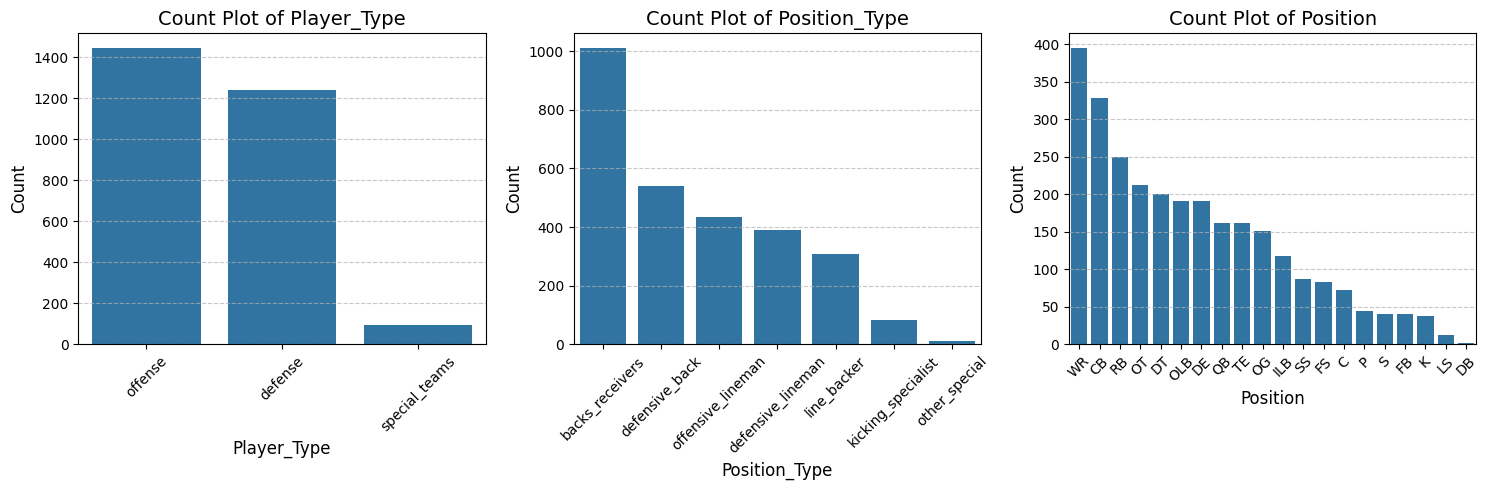

In [22]:
# カテゴリデータ（object型またはcategory型）を抽出し、School列を除外
categorical_cols = train.select_dtypes(include=['object', 'category']).columns
categorical_cols = categorical_cols.drop('School')

# グラフ描画準備
num_cols = len(categorical_cols)
rows = 1
cols = num_cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5))

if cols == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# 各カテゴリ変数でカウントプロット
for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=train, order=train[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Count Plot of {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

　水準によってデータ数に大きな差があるのが分かりました。例えば「Player_Type」列については、「special_teams」のデータ数がかなり少ないことが分かります。

　次に、カテゴリデータについて、各水準の「Drafted列」の平均値を可視化してみましょう。この可視化を行うことで、どのポジションの選手がドラフトされやすいのかを視覚的に理解することができます。

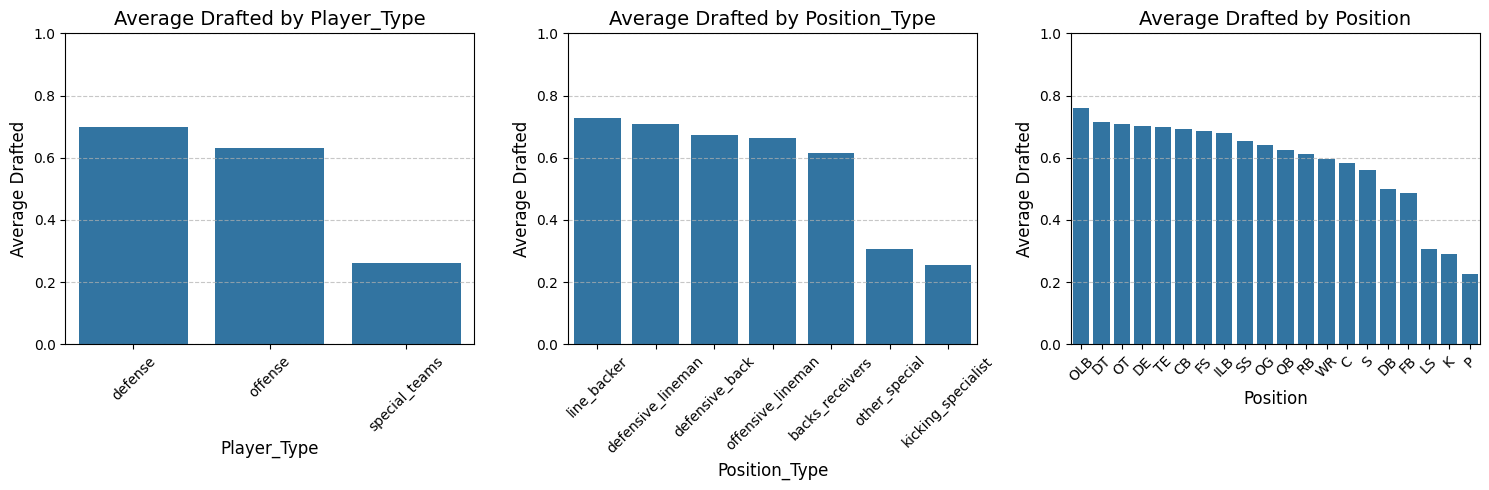

In [23]:
# カテゴリ変数（object型またはcategory型）を抽出し、School列を除外
categorical_cols = train.select_dtypes(include=['object', 'category']).columns
categorical_cols = categorical_cols.drop('School')

# グラフ描画準備
num_cols = len(categorical_cols)
rows = 1
cols = num_cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5))

if cols == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# 各カテゴリ変数ごとに Drafted 列の平均を棒グラフで描画
for i, col in enumerate(categorical_cols):
    mean_values = train.groupby(col)['Drafted'].mean().sort_values(ascending=False)
    sns.barplot(x=mean_values.index, y=mean_values.values, ax=axes[i])
    axes[i].set_title(f'Average Drafted by {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Average Drafted', fontsize=12)
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


　「Player_Type」列が「special_teams」である選手は他の選手と比べてドラフト選出される割合がかなり低いことが分かります。  
　また、「Position_Type」列が「other_special」「kicking_specialist」である選手、「Position」列が「LS」「K」「P」である選手もドラフト選出される割合が低いことが分かります。

## 4. 前処理

In [24]:
# 使わない列の削除
df_train = train.drop(columns=["Id"])
df_test = test.drop(columns=["Id"])

「Age」「Sprint_40yd」「Vertical_Jump」「Bench_Press_Reps」「Broad_Jump」「Agility_3cone」「Shuttle」列に欠損値があります。


### ランダムフォレストによる補完（ぼつ）

In [13]:
"""
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# 欠損補完の対象となる数値列を特定
numeric_cols = df_train.select_dtypes(include=np.number).columns.drop("Drafted")

# IterativeImputerのインスタンスを作成
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=200, random_state=42), # 予測に使うモデル
    max_iter=500,        # 各列の補完を繰り返す回数
    random_state=42,
    verbose=1          # 進行状況を表示
)

#

train_imputed_np = imputer.fit_transform(df_train[numeric_cols])

# transformで得られたnumpy配列をDataFrameに戻す
# この際、indexと列名を元に戻します
df_train[numeric_cols] = pd.DataFrame(train_imputed_np, columns=numeric_cols, index=df_train.index)

# Imputerをテストデータに適用（fitはせず、transformのみ）
test_imputed_np = imputer.transform(df_test[numeric_cols])

# 同様にテストデータもDataFrameに戻す
df_test[numeric_cols] = pd.DataFrame(test_imputed_np, columns=numeric_cols, index=df_test.index)
"""

'\nimport numpy as np\nimport pandas as pd\nfrom sklearn.experimental import enable_iterative_imputer\nfrom sklearn.impute import IterativeImputer\nfrom sklearn.ensemble import RandomForestRegressor\n\n# 欠損補完の対象となる数値列を特定\nnumeric_cols = df_train.select_dtypes(include=np.number).columns.drop("Drafted")\n\n# IterativeImputerのインスタンスを作成\nimputer = IterativeImputer(\n    estimator=RandomForestRegressor(n_estimators=200, random_state=42), # 予測に使うモデル\n    max_iter=500,        # 各列の補完を繰り返す回数\n    random_state=42,\n    verbose=1          # 進行状況を表示\n)\n\n# \n\ntrain_imputed_np = imputer.fit_transform(df_train[numeric_cols])\n\n# transformで得られたnumpy配列をDataFrameに戻す\n# この際、indexと列名を元に戻します\ndf_train[numeric_cols] = pd.DataFrame(train_imputed_np, columns=numeric_cols, index=df_train.index)\n\n# Imputerをテストデータに適用（fitはせず、transformのみ）\ntest_imputed_np = imputer.transform(df_test[numeric_cols])\n\n# 同様にテストデータもDataFrameに戻す\ndf_test[numeric_cols] = pd.DataFrame(test_imputed_np, columns=numeric_cols, index=

### 特徴による補完 （ぼつ）

In [14]:
"""
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# --- 特徴量(X)と目的変数(y)を明確に分離 ---
# このセルを何度実行しても良いように、元のdf_train/df_testからコピーして処理を行います。
if 'Drafted' in df_train.columns:
    X = df_train.drop('Drafted', axis=1).copy()
    y = df_train['Drafted'].copy()
else:
    # 既にこのセルが一度実行されている場合を想定
    # (Jupyter環境では変数が残っているため)
    X = df_train.copy()

X_test = df_test.copy()


# --- 各列の性質に合わせた欠損値補完 (XとX_testに対して行います) ---

# 1. Age: ポジションタイプごとの中央値で補完
age_median = X.groupby('Position_Type')['Age'].transform('median')
X['Age'] = X['Age'].fillna(age_median)
X_test['Age'] = X_test['Age'].fillna(age_median)
X['Age'] = X['Age'].fillna(X['Age'].median())
X_test['Age'] = X_test['Age'].fillna(X['Age'].median())

# 2. Bench_Press_Reps: ポジションごとの中央値で補完
bench_median = X.groupby('Position')['Bench_Press_Reps'].transform('median')
X['Bench_Press_Reps'] = X['Bench_Press_Reps'].fillna(bench_median)
X_test['Bench_Press_Reps'] = X_test['Bench_Press_Reps'].fillna(bench_median)
X['Bench_Press_Reps'] = X['Bench_Press_Reps'].fillna(X['Bench_Press_Reps'].median())
X_test['Bench_Press_Reps'] = X_test['Bench_Press_Reps'].fillna(X['Bench_Press_Reps'].median())

# 3. Agility_3cone と Shuttle: 単回帰補完
lr_agility = LinearRegression()
lr_shuttle = LinearRegression()

train_both_present = X.dropna(subset=['Agility_3cone', 'Shuttle'])
if not train_both_present.empty:
    lr_agility.fit(train_both_present[['Shuttle']], train_both_present['Agility_3cone'])
    lr_shuttle.fit(train_both_present[['Agility_3cone']], train_both_present['Shuttle'])

    # 欠損行のマスクを作成
    agility_mask_train = X['Agility_3cone'].isnull() & X['Shuttle'].notnull()
    agility_mask_test = X_test['Agility_3cone'].isnull() & X_test['Shuttle'].notnull()
    shuttle_mask_train = X['Shuttle'].isnull() & X['Agility_3cone'].notnull()
    shuttle_mask_test = X_test['Shuttle'].isnull() & X_test['Agility_3cone'].notnull()

    # 予測と補完
    if agility_mask_train.sum() > 0:
        X.loc[agility_mask_train, 'Agility_3cone'] = lr_agility.predict(X.loc[agility_mask_train, ['Shuttle']])
    if agility_mask_test.sum() > 0:
        X_test.loc[agility_mask_test, 'Agility_3cone'] = lr_agility.predict(X_test.loc[agility_mask_test, ['Shuttle']])
    if shuttle_mask_train.sum() > 0:
        X.loc[shuttle_mask_train, 'Shuttle'] = lr_shuttle.predict(X.loc[shuttle_mask_train, ['Agility_3cone']])
    if shuttle_mask_test.sum() > 0:
        X_test.loc[shuttle_mask_test, 'Shuttle'] = lr_shuttle.predict(X_test.loc[shuttle_mask_test, ['Agility_3cone']])


# 4. k-NNのためにカテゴリ変数を数値化
categorical_cols = ['Player_Type', 'Position_Type', 'Position', 'School']
label_encoders = {}

# 元のインデックスを保持
train_index = X.index
test_index = X_test.index

for col in categorical_cols:
    le = LabelEncoder()
    # trainとtestを結合してfitさせ、未知のカテゴリに対応
    combined_data = pd.concat([X[col].astype(str), X_test[col].astype(str)])
    le.fit(combined_data)
    X[col] = le.transform(X[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le # 後で元に戻すために保存

# k-NN Imputerの準備と実行
imputer_knn = KNNImputer(n_neighbors=5)
# fit_transformは特徴量(X)のみで行います
X_imputed_np = imputer_knn.fit_transform(X)
X_test_imputed_np = imputer_knn.transform(X_test)

# DataFrameに戻す（この時点ではまだカテゴリ列は数値）
df_train = pd.DataFrame(X_imputed_np, columns=X.columns, index=train_index)
df_test = pd.DataFrame(X_test_imputed_np, columns=X_test.columns, index=test_index)


# 5. ラベルエンコーディングしたカテゴリカル変数を元の文字列に戻す
for col in categorical_cols:
    # 整数型に変換してから逆変換
    df_train[col] = df_train[col].astype(int)
    df_test[col] = df_test[col].astype(int)

    # 逆変換を実行
    df_train[col] = label_encoders[col].inverse_transform(df_train[col])
    df_test[col] = label_encoders[col].inverse_transform(df_test[col])

# 最後に学習データに目的変数を再結合
df_train['Drafted'] = y
"""

"\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.impute import KNNImputer\nfrom sklearn.preprocessing import LabelEncoder\nimport pandas as pd\n\n# --- 特徴量(X)と目的変数(y)を明確に分離 ---\n# このセルを何度実行しても良いように、元のdf_train/df_testからコピーして処理を行います。\nif 'Drafted' in df_train.columns:\n    X = df_train.drop('Drafted', axis=1).copy()\n    y = df_train['Drafted'].copy()\nelse:\n    # 既にこのセルが一度実行されている場合を想定\n    # (Jupyter環境では変数が残っているため)\n    X = df_train.copy()\n    \nX_test = df_test.copy()\n\n\n# --- 各列の性質に合わせた欠損値補完 (XとX_testに対して行います) ---\n\n# 1. Age: ポジションタイプごとの中央値で補完\nage_median = X.groupby('Position_Type')['Age'].transform('median')\nX['Age'] = X['Age'].fillna(age_median)\nX_test['Age'] = X_test['Age'].fillna(age_median)\nX['Age'] = X['Age'].fillna(X['Age'].median())\nX_test['Age'] = X_test['Age'].fillna(X['Age'].median())\n\n# 2. Bench_Press_Reps: ポジションごとの中央値で補完\nbench_median = X.groupby('Position')['Bench_Press_Reps'].transform('median')\nX['Bench_Press_Reps'] = X['Bench_Press_Reps'

### BayesianRidgeで補完

In [26]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# 特徴量(X)と目的変数(y)を明確に分離
# 元のデータフレームをコピーして使用
X = df_train.drop('Drafted', axis=1).copy()
y = df_train['Drafted'].copy()
X_test = df_test.copy()

# 欠損値のある数値カラムを特定
numerical_cols_with_na = [
    'Age', 'Sprint_40yd', 'Vertical_Jump',
    'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Shuttle'
]

# One-Hotエンコーディング
categorical_cols = ['Player_Type', 'Position_Type', 'Position', 'School']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# 訓練データとテストデータを結合してエンコーダーを学習させ、未知のカテゴリに対応
combined_categorical = pd.concat([X[categorical_cols], X_test[categorical_cols]], axis=0)
encoded_categorical_combined = encoder.fit_transform(combined_categorical)

# 訓練データとテストデータに分割
encoded_categorical_train = encoded_categorical_combined[:len(X)]
encoded_categorical_test = encoded_categorical_combined[len(X):]

# One-Hotエンコードされた特徴名を生成
ohe_feature_names = encoder.get_feature_names_out(categorical_cols)

# DataFrameに変換
X_train_ohe = pd.DataFrame(encoded_categorical_train, index=X.index, columns=ohe_feature_names)
X_test_ohe = pd.DataFrame(encoded_categorical_test, index=X_test.index, columns=ohe_feature_names)

# 元のデータフレームからカテゴリカル列を削除し、One-Hotエンコードしたものを結合
X = X.drop(columns=categorical_cols)
X_test = X_test.drop(columns=categorical_cols)
X = pd.concat([X, X_train_ohe], axis=1)
X_test = pd.concat([X_test, X_test_ohe], axis=1)


# IterativeImputerによる多変量代入
imputer = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=50,
    random_state=42,
    verbose=1
)

# 訓練データでimputerを学習させ、訓練・テスト両方を変換
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.transform(X_test)

# DataFrameに戻す
df_train_imputed = pd.DataFrame(X_imputed, columns=X.columns, index=df_train.index)
df_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns, index=df_test.index)

# 欠損値補完後のデータフレームを更新
df_train = df_train_imputed.copy()
df_test = df_test_imputed.copy()

# 目的変数を再結合
df_train['Drafted'] = y


[IterativeImputer] Completing matrix with shape (2781, 293)
[IterativeImputer] Change: 50.174320532911175, scaled tolerance: 2.019 
[IterativeImputer] Change: 24.29743732255167, scaled tolerance: 2.019 
[IterativeImputer] Change: 11.027405020963513, scaled tolerance: 2.019 
[IterativeImputer] Change: 5.283924152898194, scaled tolerance: 2.019 
[IterativeImputer] Change: 3.2697596232962027, scaled tolerance: 2.019 
[IterativeImputer] Change: 2.056398804201696, scaled tolerance: 2.019 
[IterativeImputer] Change: 1.2889416188190186, scaled tolerance: 2.019 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (696, 293)
--- 補完後の欠損値数 ---
Age                 0
Sprint_40yd         0
Vertical_Jump       0
Bench_Press_Reps    0
Broad_Jump          0
Agility_3cone       0
Shuttle             0
dtype: int64

Age                 0
Sprint_40yd         0
Vertical_Jump       0
Bench_Press_Reps    0
Broad_Jump          0
Agility_3cone       0
Shuttle   

　欠損値があるかを確認してみましょう。

In [ ]:
print(df_train.isnull().sum())
print()
print(df_test.isnull().sum())

　これで、trainとtestの欠損値がなくなりました。  

　次に、モデルに入力するために、カテゴリデータを数値データに変換しましょう。ほとんどの機械学習モデルは、入力として数値データのみを受け付けます。  

　ここではラベルエンコーディングという手法を使います。

In [ ]:
"""
# カテゴリデータをラベルエンコーディング
label_encoders = {}
for c in ["Player_Type", "Position_Type", "Position", "School"]:
    label_encoders[c] = LabelEncoder()
    df_train[c] = label_encoders[c].fit_transform(train[c].astype(str))
    df_test[c] = df_test[c].map(lambda s: -1 if s not in label_encoders[c].classes_ else label_encoders[c].transform([s])[0])
"""

## 5. ベースラインモデル

　データの整形ができたので、このデータを入力とし、ベースラインモデルを構築します。 ベースラインモデルとは、まず最初に構築するシンプルな機械学習モデルのことです。

　今回は、**ランダムフォレスト（Random Forest）**という決定木ベースのモデルを使用します。ランダムフォレストは、多数の決定木（Decision Tree）を組み合わせて予測を行うモデルです。

　決定木とは、「はい」「いいえ」のような分岐を繰り返しながらデータを分類・予測する、非常に直感的なモデルです。たとえば、「身長が170cmより高いか？」「ポジションはキッカーか？」など、条件を一つずつたどって最終的な答えにたどり着くようなイメージです。

　ただし、1本の決定木だけで予測すると、訓練データにぴったり合わせすぎてしまい、新しいデータにはうまく対応できないことがあります（これを過学習といいます）。そこでランダムフォレストでは、同じような決定木を何十本も作り、それぞれ少しずつ異なるデータや特徴量を使って学習させます。そして、それらすべての木の予測結果を集めて、平均を取ることで、より安定した予測を実現します。

　また、モデルの性能を確かめるために、**クロスバリデーション（交差検証）**という方法を使います。これは、データをいくつかのグループに分けて、何度も訓練と評価を繰り返す手法です。

　今回は、データを5つに分け、毎回1つのグループを「評価用」、残りの4つを「訓練用」として使い、これを5回繰り返します。その結果を平均して、モデルの性能を評価しています。クロスバリデーションは、信頼度の高いスコアを得ることができるのが強みです。

In [27]:
# 特徴量と目的変数に分ける
X = df_train.drop(columns=["Drafted"])
y = df_train["Drafted"]

# モデルとCVの設定
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=2025
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# スコア格納用
auc_scores = []

# Stratified K-Fold による学習と評価
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # モデル学習
    model.fit(X_train, y_train)

    # 予測とスコアリング
    y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_valid_pred_proba)
    auc_scores.append(auc)
    print(f"  AUC: {round(auc, 4)}")

# 平均AUCを表示
mean_auc = np.mean(auc_scores)
print("\nAverage Validation AUC:", round(mean_auc, 4))

Fold 1
  AUC: 0.7013
Fold 2
  AUC: 0.7475
Fold 3
  AUC: 0.7811
Fold 4
  AUC: 0.6843
Fold 5
  AUC: 0.7449

Average Validation AUC: 0.7318


　このモデルはAUCスコア「0.8115」を記録しました。

## 6. 仮説と特徴量エンジニアリング

　ここでは、**特徴量エンジニアリング**を行います。

　特徴量エンジニアリングは、元のデータからモデルがより有効に学習できるような情報（特徴量）を作成するプロセスです。モデルの性能を高めるための重要なステップの1つです。

　ここでは、「身長と体重から算出されるBMIという肥満度指標は、選手の情報として有益かもしれない」という仮説をもとに、「身長 / (体重の2乗)」を算出して新たな特徴量とします。

In [28]:
for df in [df_train, df_test]:
    df['BMI'] = df['Weight'] / (df['Height'] ** 2)

　新たに作成した特徴量を含め、もう一度スコアを出してみましょう。

In [29]:
# 特徴量と目的変数に分ける
X = df_train.drop(columns=["Drafted"])
y = df_train["Drafted"]

# モデルとCVの設定
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=2025
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# スコア・予測格納用
auc_scores = []
test_pred_proba_list = []

# Stratified K-Fold による学習と評価
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # モデル学習
    model.fit(X_train, y_train)

    # バリデーション予測 & スコア
    y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_valid_pred_proba)
    auc_scores.append(auc)
    print(f"  AUC: {round(auc, 4)}")

    # テストデータ予測を保存
    test_pred_proba = model.predict_proba(df_test)[:, 1]
    test_pred_proba_list.append(test_pred_proba)

# 平均AUCを表示
mean_auc = np.mean(auc_scores)
print("\nAverage Validation AUC:", round(mean_auc, 4))

# テスト予測の平均を計算
test_pred_proba_mean = np.mean(test_pred_proba_list, axis=0)

Fold 1
  AUC: 0.6849
Fold 2
  AUC: 0.765
Fold 3
  AUC: 0.7902
Fold 4
  AUC: 0.7073
Fold 5
  AUC: 0.7303

Average Validation AUC: 0.7355


　一部の機械学習モデルでは、入力した特徴量の重要度を計算することができます。特徴量重要度を可視化してみましょう。

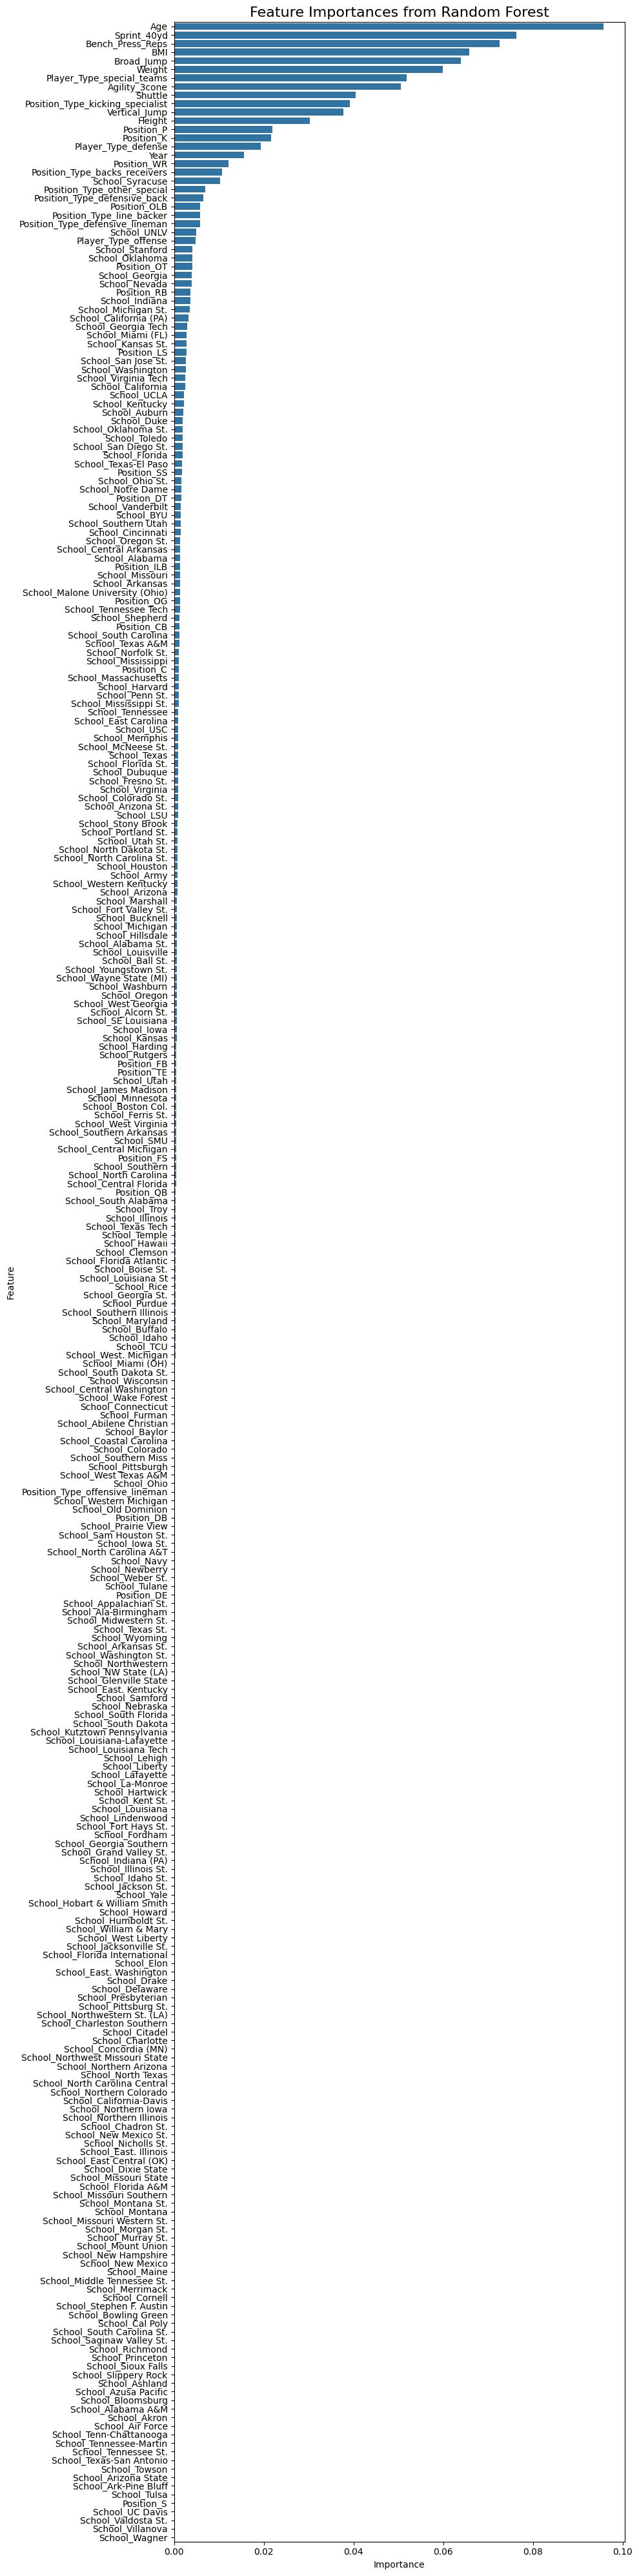

In [35]:
# 特徴量とその重要度をDataFrameにまとめる
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 可視化
plt.figure(figsize=(10, 40 )) # Adjusting the figure size to make the plot taller
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.title('Feature Importances from Random Forest', fontsize=16)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

　新たに作った特徴量「BMI」列は、重要度は比較的高いことが分かりました。

## 7. 提出ファイル作成

In [31]:
import datetime
dt_now = datetime.datetime.now()
time_now = dt_now.strftime('%m%d_%H%M')

submission = pd.read_csv(PATH + 'sample_submission.csv') # PATHは必要に応じて変更の必要があります
submission["Drafted"] = test_pred_proba_mean
submission.to_csv(PATH + f'submission/baseline_submission_{dt_now}.csv', index=False)

## 8. 今後の展望

　本ノートブックでは、データの前処理から特徴量エンジニアリング、モデル構築、評価まで、ベースラインモデルの構築を行いました。

　今後はこのベースラインを土台として、さらに高度な特徴量の工夫やアルゴリズムの改善などによって精度向上を目指していくことができます。例えば、以下のような工夫が考えられます。

- カテゴリデータのエンコーディング手法の変更
- 欠損値の補完手法の変更
- 別のモデルの検討
- モデルのハイパーパラメータ調整
- 特徴量エンジニアリング


　高スコア獲得を目指して、頑張りましょう！